In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [3]:
df = pd.read_csv("data/ames.csv")

First, I will choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates. 

In [6]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64

Before we go further, choose which features I would like to apply a target encoding to. Categorical features with a large number of categories are often good candidates. I will use `value_counts` method.

In [8]:
df["Neighborhood"].value_counts()

Neighborhood
North_Ames                                 443
College_Creek                              267
Old_Town                                   239
Edwards                                    194
Somerset                                   182
Northridge_Heights                         166
Gilbert                                    165
Sawyer                                     151
Northwest_Ames                             131
Sawyer_West                                125
Mitchell                                   114
Brookside                                  108
Crawford                                   103
Iowa_DOT_and_Rail_Road                      93
Timberland                                  72
Northridge                                  71
Stone_Brook                                 51
South_and_West_of_Iowa_State_University     48
Clear_Creek                                 44
Meadow_Village                              37
Briardale                                   30


## 1) Choose Features for Encoding¶
Target encoding works best on variable that has many categories, some of them are `Neighborhood`, `MSSubClass`, `Exterior2nd`, `Exterior1st`, `OverallQual` and `SaleType`.

I will apply target encoding on `Neighborhood`. To avoid overfitting, I will fit the encoder on data heldout from the training set.

In [10]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

## 2) Apply M-Estimate Encoding
I will apply m-estimate encoding to the neighborhood

In [21]:
encoder = MEstimateEncoder(cols=["Neighborhood"], m = 6.0) # MEstimate Encoder instance

encoder.fit(X_encode, y_encode) # encoder fitting

# Encode Training split
X_train = encoder.transform(X_pretrain, y_train)

See how the encoded feature compares to the target

Text(0.5, 0, 'SalePrice')

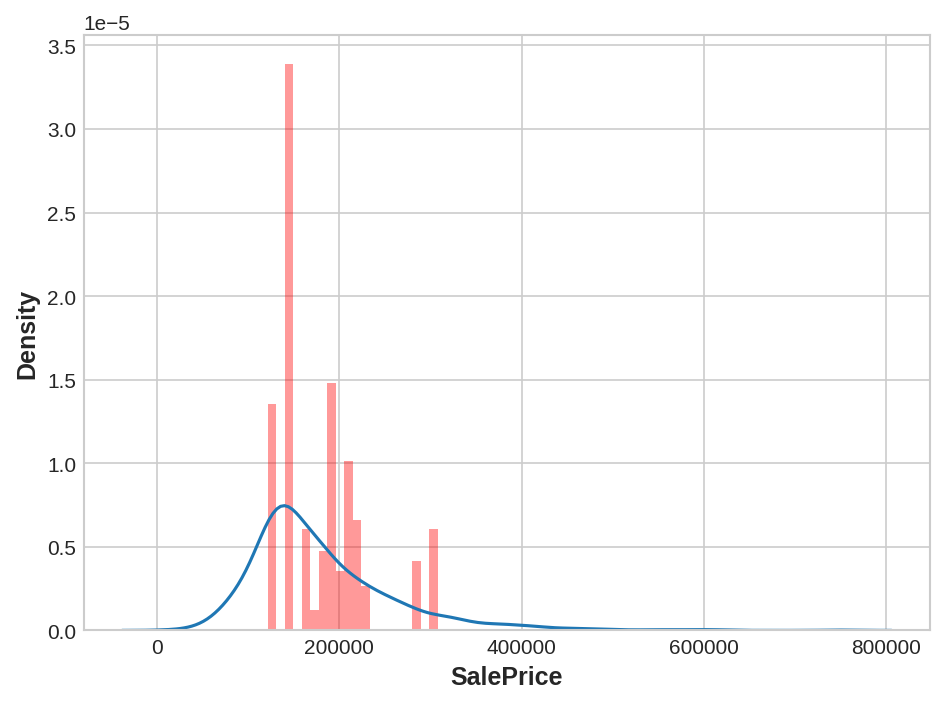

In [22]:
feature = encoder.cols

plt.figure(dpi=150)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice")

I am now exploring the problem of overfitting with target encodings. This will illustrate the importance of training fitting target encoders on data held-out from the training set.

So let's see what happens when we fit the encoder and the model on the same dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with SalePrice, a count: 0, 1, 2, 3, 4, 5, ....

In [27]:
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score = score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0375 RMSLE


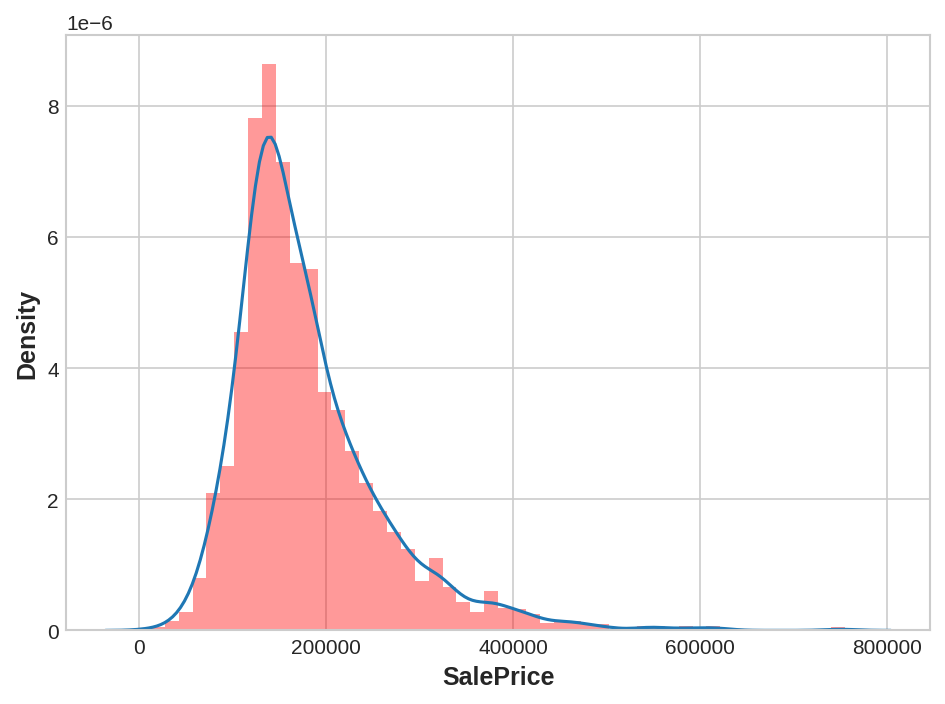

In [28]:
plt.figure(dpi=150)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

The distributions are almost exactly the same

## 3) Overfitting with Target Encoders

Since Count never has any duplicate values, the mean-encoded Count is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!